In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import nltk
import json
import string
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 5.3 MB 36.6 MB/s 
     |████████████████████████████████| 1.3 MB 41.4 MB/s 
     |████████████████████████████████| 163 kB 50.3 MB/s 
     |████████████████████████████████| 7.6 MB 46.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ad0ea6a6b5167411569e41ee6fc07fbe38c120dcefb2b42406fec1b0d525d00c
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
df_pos = pd.read_csv('/content/drive/MyDrive/ENGI 4800/data/Software_Matched_Sentences.csv', index_col=False)[['Stemmed','Label']]
df_pos['Label'] = df_pos['Label'].fillna(1).astype('int')
df_neg = pd.read_csv('/content/drive/MyDrive/ENGI 4800/data/Software_Unmatched_Sentences.csv', index_col=False)[['Stemmed','Label']]
df_neg['Label'] = df_neg['Label'].fillna(0).astype('int')
df = pd.concat([df_pos, df_neg])
m, n = df.shape
df.index = np.arange(m)

In [ ]:
df_pos

,Stemmed,Label
0,data curat softwar formal analysi write review...,1
1,biomed engin analyz eeg data matlab softwar,0
2,conceptu methodolog softwar valid formal analy...,1
3,softwar,1
4,conceptu write origin draft supervis project a...,1
...,...,...
95,valid softwar,1
96,write – origin draft softwar ds resourc superv...,1
97,softwar mq,1
98,softwar dongdong visual jiefeng zhiqian zhiyu ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Stemmed  205 non-null    object
 1   Label    205 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


In [ ]:
df['Label'].value_counts()

0    109
1     96
Name: Label, dtype: int64

## Sentences embeddings

### TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tf_embeddings = tf.fit_transform(df['Stemmed']).toarray()
tf_embeddings.shape

(205, 282)

### SBERT

In [ ]:
#Sbert
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
sbert_embeddings = model.encode(df['Stemmed'])
sbert_embeddings.shape

(205, 768)

## Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
label = np.array(df['Label'])

train_tfidf_embeddings, test_tfidf_embeddings, train_tfidf_labels, test_tfidf_labels = train_test_split(tf_embeddings, label,\
                                                                                                        test_size = 0.1, stratify = label, random_state = 42)

train_num = train_tfidf_labels.shape[0]
test_num = test_tfidf_labels.shape[0]
print('Number of training samples: {} and number of testing samples: {}'.format(train_num, test_num))


Number of training samples: 184 and number of testing samples: 21


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)
tf_cv = cross_validate(lr, tf_embeddings, label, cv=5,\
                     scoring=('accuracy', 'f1', 'roc_auc'),\
                     groups = label,\
                     return_train_score=True)

print('Tfidf training accuracy {}, f1-score {}, auc score {}'.format(np.mean(tf_cv['train_accuracy']),\
                                                                     np.mean(tf_cv['train_f1']),\
                                                                     np.mean(tf_cv['train_roc_auc'])))
                                                                        
      
print('Tfidf testing accuracy {}, f1-score {}, auc score {}'.format(np.mean(tf_cv['test_accuracy']),\
                                                                    np.mean(tf_cv['test_f1']),\
                                                                    np.mean(tf_cv['test_roc_auc'])))

Tfidf training accuracy 0.9536585365853659, f1-score 0.9486067632709071, auc score 0.9952515006167456
Tfidf testing accuracy 0.9121951219512194, f1-score 0.899091166831105, auc score 0.9688995215311005


In [ ]:
"""
from sklearn.metrics import f1_score, roc_auc_score
#train_tfidf_embeddings = np.concatenate([tf_embeddings[:90], tf_embeddings[110:]])
#test_tfidf_embeddings = tf_embeddings[90:110]

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_tfidf_embeddings, train_tfidf_labels)
print('Tfidf training accuracy {}, f1-score {}, auc score {}'.format(sum(lr.predict(train_tfidf_embeddings) == train_tfidf_labels)/train_num,\
                                                               f1_score(train_tfidf_labels,lr.predict(train_tfidf_embeddings)),\
                                                               roc_auc_score(train_tfidf_labels,lr.predict(train_tfidf_embeddings))))
                                                                        
      
print('Tfidf testing accuracy {}, f1-score {}, auc score {}'.format(sum(lr.predict(test_tfidf_embeddings) == test_tfidf_labels)/test_num,\
                                                               f1_score(test_tfidf_labels,lr.predict(test_tfidf_embeddings)),\
                                                               roc_auc_score(test_tfidf_labels,lr.predict(test_tfidf_embeddings))))
""";

In [ ]:
train_sbert_embeddings, test_sbert_embeddings, train_sbert_labels, test_sbert_labels = train_test_split(sbert_embeddings, label,\
                                                                                                        test_size = 0.1, stratify = label, random_state = 2511)

train_num = train_sbert_labels.shape[0]
test_num = test_sbert_labels.shape[0]
#print('Number of training samples: {} and number of testing samples: {}'.format(train_num, test_num))

In [ ]:
lr = LogisticRegression(random_state = 42)
sbert_cv = cross_validate(lr, sbert_embeddings, label, cv=5,\
                     scoring=('accuracy', 'f1', 'roc_auc'),\
                     groups = label,\
                     return_train_score=True)

print('Tfidf training accuracy {}, f1-score {}, auc score {}'.format(np.mean(sbert_cv['train_accuracy']),\
                                                                     np.mean(sbert_cv['train_f1']),\
                                                                     np.mean(sbert_cv['train_roc_auc'])))
                                                                        
      
print('Tfidf testing accuracy {}, f1-score {}, auc score {}'.format(np.mean(sbert_cv['test_accuracy']),\
                                                                    np.mean(sbert_cv['test_f1']),\
                                                                    np.mean(sbert_cv['test_roc_auc'])))

Tfidf training accuracy 1.0, f1-score 1.0, auc score 1.0
Tfidf testing accuracy 0.9609756097560975, f1-score 0.9569191677535708, auc score 0.9909273182957392


In [ ]:
"""
lr = LogisticRegression()
lr.fit(train_sbert_embeddings, train_sbert_labels)
print('Sbert training accuracy {}, f1-score {}, auc score {}'.format(sum(lr.predict(train_sbert_embeddings) == train_sbert_labels)/train_num,\
                                                               f1_score(train_sbert_labels,lr.predict(train_sbert_embeddings)),\
                                                               roc_auc_score(train_sbert_labels,lr.predict(train_sbert_embeddings))))
                                                                        
      
print('Sbert testing accuracy {}, f1-score {}, auc score {}'.format(sum(lr.predict(test_sbert_embeddings) == test_sbert_labels)/test_num,\
                                                               f1_score(test_sbert_labels,lr.predict(test_sbert_embeddings)),\
                                                               roc_auc_score(test_sbert_labels,lr.predict(test_sbert_embeddings))))
""";

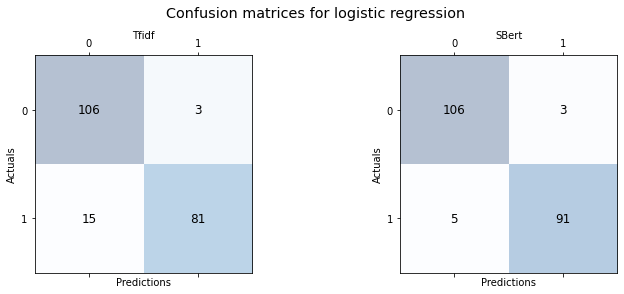

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

tf_label_pred = cross_val_predict(lr, tf_embeddings, label, cv=5, groups = label)
tf_conf_matrix = confusion_matrix(tf_label_pred, label)

sbert_label_pred = cross_val_predict(lr, sbert_embeddings, label, cv=5, groups = label)
sbert_conf_matrix = confusion_matrix(sbert_label_pred, label)

fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

ax[0].matshow(tf_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(tf_conf_matrix.shape[0]):
    for j in range(tf_conf_matrix.shape[1]):
        ax[0].text(x=i, y=j,s=tf_conf_matrix[i, j], va='center', ha='center', size='large')

ax[1].matshow(sbert_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(sbert_conf_matrix.shape[0]):
    for j in range(sbert_conf_matrix.shape[1]):
        ax[1].text(x=i, y=j,s=sbert_conf_matrix[i, j], va='center', ha='center', size='large')
 
ax[0].set_xlabel('Predictions', fontsize=10)
ax[0].set_ylabel('Actuals', fontsize=10)
ax[0].set_title('Tfidf', fontsize=10)

ax[1].set_xlabel('Predictions', fontsize=10)
ax[1].set_ylabel('Actuals', fontsize=10)
ax[1].set_title('SBert', fontsize=10)

st = fig.suptitle("Confusion matrices for logistic regression", fontsize="x-large")
st.set_y(1.05)
plt.savefig('/content/drive/MyDrive/ENGI 4800/data/logistic_conf.jpg', bbox_inches = 'tight')

In [ ]:
df['Stemmed'][(sbert_label_pred==1) & (label == 0)][122]

'perform cell cultur perform biolog assay conduct western blot analysi plane studi analyz data wrote draft'

# Clustering

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [ ]:
km_tfidf = KMeans(n_clusters=2, init='k-means++',random_state = 42)
km_tfidf.fit(tf_embeddings)
print('Accuracy of KMeans on Tfidf embeddings {}'.format(sum(km_tfidf.labels_ == label)/len(label)))

Accuracy of KMeans on Tfidf embeddings 0.8292682926829268


In [ ]:
km_sbert = KMeans(n_clusters=2, init='k-means++', random_state = 42)
km_sbert.fit(sbert_embeddings)
print('Accuracy of KMeans clustering on Sbert embeddings {}'.format(sum(km_sbert.labels_ == label)/len(label)))

Accuracy of KMeans clustering on Sbert embeddings 0.7073170731707317


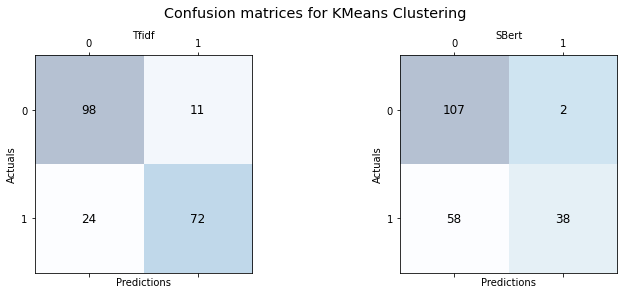

In [ ]:
tf_conf_matrix = confusion_matrix(km_tfidf.labels_, label)

sbert_conf_matrix = confusion_matrix(km_sbert.labels_, label)

fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

ax[0].matshow(tf_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(tf_conf_matrix.shape[0]):
    for j in range(tf_conf_matrix.shape[1]):
        ax[0].text(x=i, y=j,s=tf_conf_matrix[i, j], va='center', ha='center', size='large')

ax[1].matshow(sbert_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(sbert_conf_matrix.shape[0]):
    for j in range(sbert_conf_matrix.shape[1]):
        ax[1].text(x=i, y=j,s=sbert_conf_matrix[i, j], va='center', ha='center', size='large')
 
ax[0].set_xlabel('Predictions', fontsize=10)
ax[0].set_ylabel('Actuals', fontsize=10)
ax[0].set_title('Tfidf', fontsize=10)

ax[1].set_xlabel('Predictions', fontsize=10)
ax[1].set_ylabel('Actuals', fontsize=10)
ax[1].set_title('SBert', fontsize=10)

st = fig.suptitle("Confusion matrices for KMeans Clustering", fontsize="x-large")
st.set_y(1.05)
plt.savefig('/content/drive/MyDrive/ENGI 4800/data/kmeans_conf.jpg', bbox_inches = 'tight')

In [ ]:
"""
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(tf_embeddings)
PCA_components = pd.DataFrame(principalComponents)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, c=label)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
centers = km_tfidf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
""";


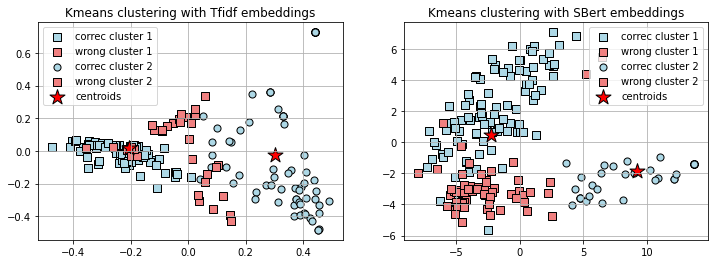

In [ ]:
from sklearn.decomposition import PCA
pca_tfe = PCA(n_components=2)
X_tfe = pca_tfe.fit_transform(tf_embeddings)
y_km_tfe = km_tfidf.labels_
centers_tfe = pca_tfe.transform(km_tfidf.cluster_centers_)

fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

ax[0].scatter(
    X_tfe [(y_km_tfe == 0) &(label ==0), 0], X_tfe [(y_km_tfe == 0) &(label ==0), 1],
    s=50, c='lightblue',
    marker='s',edgecolor='black',
    label='correc cluster 1'
)

ax[0].scatter(
    X_tfe[((y_km_tfe == 0) &(label ==1)), 0], X_tfe [((y_km_tfe == 0) &(label ==1)), 1],
    s=50, c='lightcoral',
    marker='s', edgecolor='black',
    label='wrong cluster 1'
)


ax[0].scatter(
    X_tfe[((y_km_tfe == 1) & (label ==1)), 0], X_tfe[((y_km_tfe == 1) &(label ==1)), 1],
    s=50, c='lightblue',
    marker='o',edgecolor='black',
    label='correc cluster 2'
)

ax[0].scatter(
    X_tfe [((y_km_tfe == 1) &(label ==0)), 0], X_tfe[((y_km_tfe == 1) &(label ==0)), 1],
    s=50, c='lightcoral',
    marker='s',edgecolor='black',
    label='wrong cluster 2'
)

pca_sbert = PCA(n_components=2)
X_sbert = pca_sbert.fit_transform(sbert_embeddings)
y_km_sbert = km_sbert.labels_
centers_sbert = pca_sbert.transform(km_sbert.cluster_centers_)

# plot the centroids
ax[0].scatter(
    centers_tfe[:, 0], centers_tfe[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

ax[0].legend(scatterpoints=1)
ax[0].grid()
ax[0].set_title("Kmeans clustering with Tfidf embeddings")


ax[1].scatter(
    X_sbert [(y_km_sbert == 0) &(label ==0), 0], X_sbert [(y_km_sbert == 0) &(label ==0), 1],
    s=50, c='lightblue',
    marker='s',edgecolor='black',
    label='correc cluster 1'
)

ax[1].scatter(
    X_sbert[((y_km_sbert == 0) &(label ==1)), 0], X_sbert [((y_km_sbert == 0) &(label ==1)), 1],
    s=50, c='lightcoral',
    marker='s', edgecolor='black',
    label='wrong cluster 1'
)


ax[1].scatter(
    X_sbert[((y_km_sbert == 1) & (label ==1)), 0], X_sbert[((y_km_sbert == 1) &(label ==1)), 1],
    s=50, c='lightblue',
    marker='o',edgecolor='black',
    label='correc cluster 2'
)

ax[1].scatter(
    X_sbert [((y_km_sbert == 1) &(label ==0)), 0], X_sbert[((y_km_sbert == 1) &(label ==0)), 1],
    s=50, c='lightcoral',
    marker='s',edgecolor='black',
    label='wrong cluster 2'
)

# plot the centroids
ax[1].scatter(
    centers_sbert[:, 0], centers_sbert[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

ax[1].legend(scatterpoints=1)
ax[1].grid()
ax[1].set_title("Kmeans clustering with SBert embeddings")


plt.savefig('/content/drive/MyDrive/ENGI 4800/data/clusters.jpg', bbox_inches = 'tight')

In [ ]:
agg_tfidf = AgglomerativeClustering(n_clusters=2)
agg_tfidf.fit(tf_embeddings)
sum(agg_tfidf.labels_ == label)
print('Accuracy of Hierarchical clustering on Tfidf embeddings {}'.format(sum(agg_tfidf.labels_ == label)/len(label)))

Accuracy of Hierarchical clustering on Tfidf embeddings 0.5902439024390244


In [ ]:
agg_sbert = AgglomerativeClustering(n_clusters=2)
agg_sbert.fit(sbert_embeddings)
sum(agg_sbert.labels_ == label)
print('Accuracy of Hierarchical clustering on Sbert embeddings {}'.format(sum(agg_sbert.labels_ == label)/len(label)))

Accuracy of Hierarchical clustering on Sbert embeddings 0.624390243902439


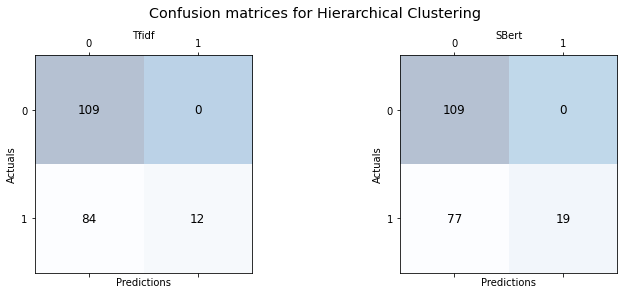

In [ ]:
tf_conf_matrix = confusion_matrix(agg_tfidf.labels_, label)

sbert_conf_matrix = confusion_matrix(agg_sbert.labels_, label)

fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

ax[0].matshow(tf_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(tf_conf_matrix.shape[0]):
    for j in range(tf_conf_matrix.shape[1]):
        ax[0].text(x=i, y= j,s=tf_conf_matrix[i, j], va='center', ha='center', size='large')

ax[1].matshow(sbert_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(sbert_conf_matrix.shape[0]):
    for j in range(sbert_conf_matrix.shape[1]):
        ax[1].text(x=i, y=j,s=sbert_conf_matrix[i, j], va='center', ha='center', size='large')
 
ax[0].set_xlabel('Predictions', fontsize=10)
ax[0].set_ylabel('Actuals', fontsize=10)
ax[0].set_title('Tfidf', fontsize=10)

ax[1].set_xlabel('Predictions', fontsize=10)
ax[1].set_ylabel('Actuals', fontsize=10)
ax[1].set_title('SBert', fontsize=10)

st = fig.suptitle("Confusion matrices for Hierarchical Clustering", fontsize="x-large")
st.set_y(1.05)
plt.savefig('/content/drive/MyDrive/ENGI 4800/data/hier_conf.jpg', bbox_inches = 'tight')

In [ ]:
"""
X_tfe = pca.fit_transform(tf_embeddings)
y_atf = agg_tfidf.labels_
centers = pca.transform(agg_tfidf.cluster_centers_)
plt.scatter(
    X_tfe [(y_atf == 0) &(label ==0), 0], X_tfe [(y_atf == 0) &(label ==0), 1],
    s=50, c='lightblue',
    marker='s',
    label='cluster 1 with correct label'
)

plt.scatter(
    X_tfe[((y_atf == 0) &(label ==1)), 0], X_tfe [((y_atf == 0) &(label ==1)), 1],
    s=50, c='lightcoral',
    marker='s',
    label='cluster 1 with wrong label'
)


plt.scatter(
    X_tfe[((y_atf == 1) & (label ==1)), 0], X_tfe[((y_atf == 1) &(label ==1)), 1],
    s=50, c='lightblue',
    marker='o',
    label='cluster 2 with correct label'
)

plt.scatter(
    X_tfe [((y_atf == 1) &(label ==0)), 0], X_tfe[((y_atf == 1) &(label ==0)), 1],
    s=50, c='lightcoral',
    marker='s',
    label='cluster 2 with wrong label'
)

# plot the centroids
plt.scatter(
    centers[:, 0], centers[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.title("text embeddings for Hierarchical Clustering")
""";

In [ ]:

"""
X_sber = pca.fit_transform(sbert_embeddings)
y_agg_sbert= agg_sbert.labels_
centers = pca.transform(agg_sbert.cluster_centers_)
plt.scatter(
    X_sber[(y_agg_sbert == 0) &(label ==0), 0], X_sber[(y_agg_sbert == 0) &(label ==0), 1],
    s=50, c='lightblue',
    marker='s', 
    label='cluster 1 with correct label'
)

plt.scatter(
    X_sber[((y_agg_sbert == 0) &(label ==1)), 0], X_sber[((y_agg_sbert == 0) &(label ==1)), 1],
    s=50, c='lightcoral',
    marker='s',
    label='cluster 1 with wrong label'
)


plt.scatter(
    X_sber[((y_agg_sbert == 1) & (label ==1)), 0], X_sber[((y_agg_sbert == 1) &(label ==1)), 1],
    s=50, c='lightblue',
    marker='o',
    label='cluster 2 with correct label'
)

plt.scatter(
    X_sber[((y_agg_sbert == 1) &(label ==0)), 0], X_sber[((y_agg_sbert == 1) &(label ==0)), 1],
    s=50, c='lightcoral',
    marker='s',
    label='cluster 2 with wrong label'
)

# plot the centroids
plt.scatter(
    centers[:, 0], centers[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.title("sbert for Hierarchical Clustering")
""";